# hw1_2    Author: ChiJui Chen 0510157

# Construct a convolutional neural network (CNN) for image recognition by using Stanford Dogs Dataset. This dataset consists of 1600 dog images from 8 categories.
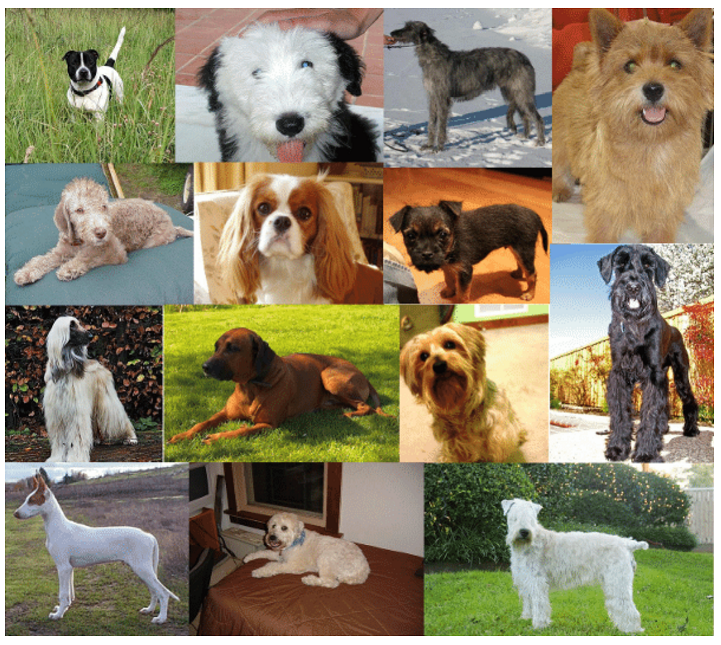

## Import packages 

In [26]:
import numpy as np
# matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

## Using gpu if it is possible

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('using: ', device)

using:  cpu


## Prepare the dataset

In [28]:
PATH = 'stanford_dogs_dataset'

# size = (224,224,3)
IMAGE_SIZE = 224

# training dataset
# some data augmentation
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(IMAGE_SIZE),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                      ])

train_data_dir = PATH + '/train' 
                          
train_data = datasets.ImageFolder(train_data_dir, transform = train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True) 





# training dataset
# no data augmentation, just crop the images
test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(IMAGE_SIZE),
                                     transforms.ToTensor()])



test_data_dir = PATH + '/test'
test_data = datasets.ImageFolder(test_data_dir, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

## Have a look of the data

In [29]:
print('classes: ',train_data.classes)

# number of classes
nb_class = len(train_data.classes)
print('number of classes: ', nb_class)

print('number of training images: ', len(train_data.imgs))
print('number of training images: ', len(test_data.imgs))

classes:  ['Afghan_hound', 'Airedale', 'Bernese_mountain_dog', 'Irish_wolfhound', 'Leonberg', 'Scottish_deerhound', 'Tibetan_terrier', 'basenji']
number of classes:  8
number of training images:  1328
number of training images:  288


# 1. Build a CNN 

In [30]:
class CNN(nn.Module):
  def __init__(self, num_classes = 1000):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=3, padding=2, out_channels=32, kernel_size=7) 
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=32, padding=2, out_channels=64, kernel_size=5)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
    self.conv3 = nn.Conv2d(in_channels=64, padding=2, out_channels=64, kernel_size=3)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 
    
        
    # Dense layer
    self.fc1 = nn.Linear(28*28*64, 512)
    self.fc2 = nn.Linear(512, num_classes)
    
    
    
    
  def forward(self, x):
    
    # conv1
    x = self.pool1(F.relu(self.conv1(x)))
        
    
    # conv2
    x = self.pool2(F.relu(self.conv2(x)))
    
    
    # conv3
    x = self.pool3(F.relu(self.conv3(x)))
    
       
    # Flatten
    x = x.view(x.size(0), -1)
    
    # dense1
    x = self.fc1(x)
    
    x = F.relu(x)
    
    # dense2
    x = self.fc2(x)
    
    
    return x

## Have a look at the CNN model

In [31]:
model_0 = CNN(nb_class).to(device)
print(model_0)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
)


## define the training function and testing function
### reference: https://androidkt.com/calculate-total-loss-and-accuracy-at-every-epoch-and-plot-using-matplotlib-in-pytorch/

In [32]:
model = model_0
train_accu_0 = []
train_losses_0 = []

def train(epoch):
    print('\nEpoch : %d'%epoch)
    
    
    model.train()
    
    
    running_loss=0
    correct=0
    total=0
    
    print("Training:", end = '')
    for i,data in enumerate(trainloader):

        inputs,labels=data[0].to(device),data[1].to(device)
        print('labels')
        print(labels)
        print('size')
        print(labels.size)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        print("#", end = '')
        
    train_loss=running_loss/len(trainloader)
    accu=100.*correct/total

    train_accu_0.append(accu)
    train_losses_0.append(train_loss)
    print()
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
     

In [33]:
eval_losses_0=[]
eval_accu_0=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for i,data in enumerate(testloader):
            images,labels=data[0].to(device),data[1].to(device)

            outputs=model(images)

            loss= criterion(outputs,labels)
            running_loss+=loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            

        test_loss=running_loss/len(testloader)
        accu=100.*correct/total

        eval_losses_0.append(test_loss)
        eval_accu_0.append(accu)

        print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

## Hyperparameters

In [34]:
# loss function
# Cross Entropy
criterion = nn.CrossEntropyLoss()

# optimizer
# SGD
lr=0.001
momentum=0.9

optimizer = optim.SGD(model.parameters(), lr, momentum) 

In [35]:
epochs=5
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)


Epoch : 1
Training:labels
tensor([0, 3, 3, 4, 5, 3, 2, 0, 4, 2, 1, 4, 1, 0, 3, 3, 6, 3, 7, 0, 1, 6, 7, 2,
        3, 2, 1, 2, 3, 0, 6, 7])
size
<built-in method size of Tensor object at 0x0000017F5ACBB040>
#labels
tensor([3, 4, 5, 0, 6, 7, 7, 2, 2, 0, 3, 2, 2, 4, 1, 2, 4, 4, 2, 5, 6, 0, 1, 0,
        7, 1, 6, 7, 7, 3, 3, 0])
size
<built-in method size of Tensor object at 0x0000017F0176F2C0>
#labels
tensor([3, 4, 3, 4, 2, 4, 6, 5, 0, 7, 7, 0, 5, 6, 7, 2, 1, 2, 2, 6, 3, 7, 5, 7,
        0, 7, 1, 0, 2, 7, 6, 7])
size
<built-in method size of Tensor object at 0x0000017F0176F9F0>
#labels
tensor([7, 2, 0, 0, 0, 1, 4, 7, 2, 3, 2, 1, 0, 2, 7, 1, 1, 4, 0, 7, 6, 6, 2, 2,
        1, 5, 6, 3, 2, 7, 4, 2])
size
<built-in method size of Tensor object at 0x0000017F0176F720>
#labels
tensor([4, 5, 0, 6, 1, 0, 3, 3, 6, 3, 0, 7, 6, 4, 4, 6, 2, 0, 7, 3, 6, 0, 3, 1,
        7, 1, 0, 7, 3, 0, 3, 6])
size
<built-in method size of Tensor object at 0x0000017F017006D0>
#labels
tensor([3, 2, 3, 7, 3, 3, 3, 1, 4

#labels
tensor([2, 3, 1, 3, 4, 2, 5, 1, 5, 6, 2, 6, 7, 2, 4, 7, 3, 7, 2, 3, 7, 6, 0, 7,
        4, 6, 1, 1, 1, 6, 5, 6])
size
<built-in method size of Tensor object at 0x0000017F0176F720>
#labels
tensor([5, 7, 7, 3, 1, 1, 2, 7, 5, 1, 2, 4, 6, 4, 0, 6, 3, 6, 0, 0, 0, 1, 6, 1,
        5, 0, 7, 3, 4, 4, 5, 0])
size
<built-in method size of Tensor object at 0x0000017F0176F950>
#labels
tensor([7, 5, 3, 1, 0, 3, 6, 7, 3, 5, 0, 7, 6, 6, 6, 1, 1, 5, 6, 1, 3, 0, 2, 3,
        1, 1, 3, 4, 6, 2, 7, 0])
size
<built-in method size of Tensor object at 0x0000017F0176FA40>
#labels
tensor([4, 7, 3, 5, 3, 4, 5, 2, 2, 0, 0, 2, 2, 2, 7, 6, 6, 3, 5, 2, 5, 7, 5, 6,
        4, 5, 5, 7, 2, 4, 5, 2])
size
<built-in method size of Tensor object at 0x0000017F0176F540>
#labels
tensor([6, 4, 7, 1, 5, 4, 4, 4, 4, 4, 2, 7, 7, 2, 0, 7, 4, 2, 4, 2, 3, 0, 0, 7,
        5, 4, 0, 3, 4, 2, 7, 7])
size
<built-in method size of Tensor object at 0x0000017F0176F7C0>
#labels
tensor([2, 3, 6, 0, 2, 2, 0, 3, 7, 7, 2, 2, 7, 4, 5,

#labels
tensor([4, 6, 2, 1, 3, 4, 3, 5, 3, 7, 2, 5, 2, 2, 2, 1, 6, 5, 5, 2, 0, 4, 3, 7,
        7, 6, 0, 1, 2, 6, 5, 7])
size
<built-in method size of Tensor object at 0x0000017F5AC13130>
#labels
tensor([2, 1, 6, 2, 0, 5, 2, 5, 4, 1, 6, 0, 5, 5, 4, 2, 1, 7, 2, 1, 5, 2, 7, 5,
        3, 5, 5, 3, 0, 1, 4, 7])
size
<built-in method size of Tensor object at 0x0000017F0176FCC0>
#labels
tensor([1, 2, 0, 0, 3, 0, 0, 3, 4, 5, 0, 2, 3, 4, 3, 4, 7, 0, 6, 6, 0, 1, 3, 7,
        0, 5, 3, 3, 4, 6, 3, 2])
size
<built-in method size of Tensor object at 0x0000017F0176FB30>
#labels
tensor([6, 3, 1, 6, 0, 3, 5, 0, 2, 2, 0, 4, 3, 0, 5, 7, 2, 2, 1, 5, 0, 1, 7, 4,
        6, 3, 1, 7, 6, 3, 0, 5])
size
<built-in method size of Tensor object at 0x0000017F0176F0E0>
#labels
tensor([0, 2, 3, 2, 6, 0, 0, 6, 2, 3, 2, 1, 6, 0, 0, 0, 6, 3, 0, 6, 6, 7, 1, 4,
        7, 4, 4, 7, 5, 2, 4, 2])
size
<built-in method size of Tensor object at 0x0000017F0176F7C0>
#labels
tensor([3, 0, 0, 6, 2, 5, 2, 0, 5, 7, 7, 0, 1, 7, 2,

#labels
tensor([3, 2, 4, 3, 7, 2, 7, 0, 6, 3, 5, 7, 0, 3, 4, 3, 1, 6, 0, 1, 4, 3, 0, 5,
        5, 1, 5, 4, 2, 6, 5, 0])
size
<built-in method size of Tensor object at 0x0000017F0176F630>
#labels
tensor([7, 3, 6, 7, 0, 2, 6, 7, 1, 3, 6, 5, 5, 7, 2, 1, 6, 7, 3, 7, 7, 7, 4, 1,
        5, 4, 4, 2, 7, 5, 6, 6])
size
<built-in method size of Tensor object at 0x0000017F0176F2C0>
#labels
tensor([2, 0, 0, 5, 5, 7, 1, 4, 0, 7, 0, 5, 4, 5, 4, 1, 6, 7, 6, 3, 5, 7, 2, 0,
        4, 3, 1, 5, 0, 2, 2, 0])
size
<built-in method size of Tensor object at 0x0000017F0176FEA0>
#labels
tensor([7, 7, 5, 1, 5, 3, 0, 0, 5, 5, 5, 5, 0, 6, 1, 3, 3, 2, 6, 0, 6, 4, 0, 4,
        1, 1, 4, 4, 2, 4, 4, 1])
size
<built-in method size of Tensor object at 0x0000017F0176FEF0>
#labels
tensor([2, 1, 5, 5, 4, 1, 1, 0, 0, 1, 1, 1, 3, 1, 4, 0, 3, 3, 0, 2, 3, 4, 3, 4,
        2, 5, 7, 7, 6, 0, 3, 5])
size
<built-in method size of Tensor object at 0x0000017F0176FD60>
#labels
tensor([1, 1, 3, 4, 2, 2, 3, 2, 3, 7, 7, 4, 2, 6, 1,

#labels
tensor([0, 2, 7, 5, 4, 6, 5, 3, 4, 0, 2, 5, 6, 2, 4, 1, 7, 1, 1, 7, 7, 5, 7, 5,
        3, 3, 0, 0, 2, 0, 5, 4])
size
<built-in method size of Tensor object at 0x0000017F0176FA90>
#labels
tensor([0, 4, 1, 2, 4, 0, 7, 0, 1, 1, 3, 7, 2, 7, 5, 2, 1, 5, 4, 4, 6, 1, 5, 0,
        3, 6, 0, 5, 6, 4, 4, 0])
size
<built-in method size of Tensor object at 0x0000017F0176F860>
#labels
tensor([2, 4, 0, 5, 6, 3, 3, 7, 4, 4, 1, 1, 6, 5, 0, 1, 2, 1, 2, 2, 1, 0, 6, 6,
        0, 7, 7, 7, 6, 4, 7, 5])
size
<built-in method size of Tensor object at 0x0000017F0176F950>
#labels
tensor([3, 7, 1, 2, 5, 2, 1, 1, 4, 6, 1, 7, 4, 4, 4, 2, 0, 4, 0, 2, 3, 0, 1, 3,
        7, 2, 0, 0, 6, 0, 4, 1])
size
<built-in method size of Tensor object at 0x0000017F0176FCC0>
#labels
tensor([3, 4, 0, 4, 4, 7, 2, 2, 4, 6, 0, 4, 6, 0, 3, 5, 3, 1, 6, 6, 6, 2, 3, 2,
        1, 7, 7, 5, 7, 2, 0, 6])
size
<built-in method size of Tensor object at 0x0000017F0176F7C0>
#labels
tensor([5, 4, 2, 4, 5, 4, 4, 0, 7, 2, 3, 5, 0, 6, 5,

# Plot the loss

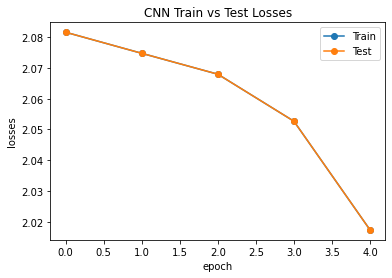

In [36]:
plt.plot(train_losses_0,'-o')
plt.plot(train_losses_0,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('CNN Train vs Test Losses')

plt.show()

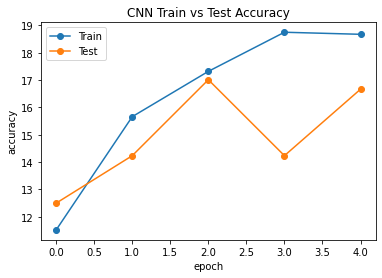

In [37]:
plt.plot(train_accu_0,'-o')
plt.plot(eval_accu_0,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('CNN Train vs Test Accuracy')

plt.show()

# 2.(a) Build a Resnet18 model
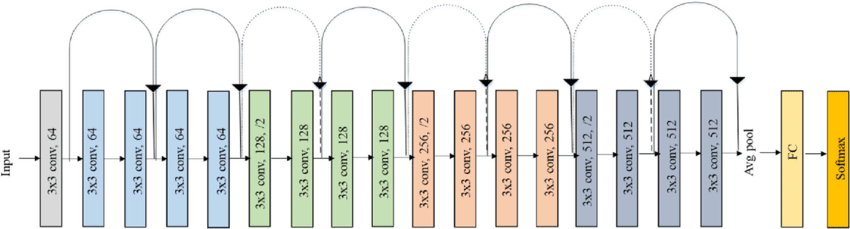

### The number of 18 refers to the number of kernels (or feature maps) that are convolved with the input. So the top conv and the FC layer are included.

### From the official resnet18 architecture, there are 8 residual blocks, each consists of 2 conv layers.

## Define the basic residual block

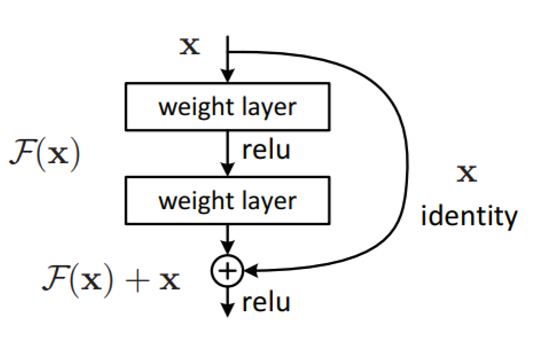

###  a BatchNorm layer is alse added after the conv layer
### reference: https://github.com/hccho2/Deep-Learning-Zero-to-All---Pytorch/blob/master/resnet.py

## Build the basicblock

In [38]:
class BasicBlock(nn.Module):
  
    def __init__(self, in_channels, filters, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, filters, kernel_size=3, stride=stride,padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(filters)
        self.relu = nn.ReLU(inplace=True)
        
        # the input channel and filter is the same for second the conv2d 
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3 ,padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(filters)
        self.stride = stride
        self.downsample = downsample

    def forward(self, x):
        
        # for the bypass
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # add the bypass
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

## Define the Resnet8 model

In [39]:
class ResNet18(nn.Module):

    def __init__(self, block, num_classes=1000):
        super(ResNet18, self).__init__()
        
        # some layers before the residual blocks
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # residual blocks
        self.layer1 = self.residual_blocks(block, 64)
        self.layer2 = self.residual_blocks(block, 128, stride=2)
        self.layer3 = self.residual_blocks(block, 256, stride=2)
        self.layer4 = self.residual_blocks(block, 512, stride=2)
        
        # Using average pooling instead of flatten like usual cnn
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dense layer
        self.fc = nn.Linear(512, num_classes)
        

    def residual_blocks(self, block, filters, stride=1):
        
        layers = []
        
        # first block
        # size correction for the bypass
        downsample = None
        if stride != 1 or self.in_channels != filters:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, filters, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(filters)
            )
            
        layers.append(block(self.in_channels, filters, stride, downsample))
        
        # second block
        # size correction for the bypass
        self.in_channels = filters        
        layers.append(block(self.in_channels, filters))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        
        # some layers before the residual blocks
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Declare a model and print the architecture

In [40]:
model_1 = ResNet18(BasicBlock, num_classes = nb_class).to(device)
print(model_1)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


## Start training resnet18
### set up the hyperparameters
### same training method as above

In [41]:
model = model_1
train_accu_1 = []
train_losses_1 = []

def train(epoch):
    print('\nEpoch : %d'%epoch)
    
    
    model.train()
    
    
    running_loss=0
    correct=0
    total=0
    
    print("Training:", end = '')
    for i,data in enumerate(trainloader):

        inputs,labels=data[0].to(device),data[1].to(device)

        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        print("#", end = '')
        
    train_loss=running_loss/len(trainloader)
    accu=100.*correct/total

    train_accu_1.append(accu)
    train_losses_1.append(train_loss)
    print()
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
     

In [42]:
# loss function
# Cross Entropy
criterion = nn.CrossEntropyLoss()

# optimizer
# SGD
lr=0.001
momentum=0.9

optimizer = optim.SGD(model.parameters(), lr, momentum) 

In [43]:
eval_losses_1=[]
eval_accu_1=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for i,data in enumerate(testloader):
            images,labels=data[0].to(device),data[1].to(device)

            outputs=model(images)

            loss= criterion(outputs,labels)
            running_loss+=loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            

        test_loss=running_loss/len(testloader)
        accu=100.*correct/total

        eval_losses_1.append(test_loss)
        eval_accu_1.append(accu)

        print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [44]:
epochs=5
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)


Epoch : 1
Training:##########################################
Train Loss: 2.009 | Accuracy: 19.503
Test Loss: 2.272 | Accuracy: 14.583

Epoch : 2
Training:##########################################
Train Loss: 1.898 | Accuracy: 27.033
Test Loss: 2.408 | Accuracy: 12.500

Epoch : 3
Training:##########################################
Train Loss: 1.857 | Accuracy: 31.099
Test Loss: 2.567 | Accuracy: 9.375

Epoch : 4
Training:##########################################
Train Loss: 1.806 | Accuracy: 33.208
Test Loss: 3.089 | Accuracy: 13.194

Epoch : 5
Training:##########################################
Train Loss: 1.749 | Accuracy: 37.726
Test Loss: 2.322 | Accuracy: 16.319


## Plot Loss

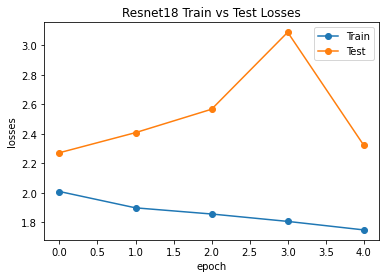

In [45]:
plt.plot(train_losses_1,'-o')
plt.plot(eval_losses_1,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Resnet18 Train vs Test Losses')

plt.show()

## Plot Accuracy

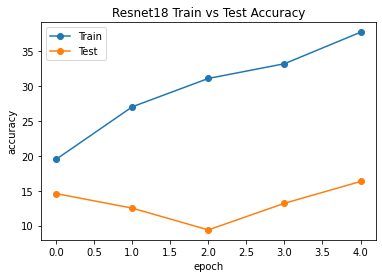

In [46]:
plt.plot(train_accu_1,'-o')
plt.plot(eval_accu_1,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Resnet18 Train vs Test Accuracy')

plt.show()

# 2. (b) remove the bypass in the residual block
## Define a different basicblock, remove the bypass in the forward propagation.

In [47]:
class BasicBlockNoBypass(nn.Module):
  
    def __init__(self, in_channels, filters, stride=1, downsample=None):
        super(BasicBlockNoBypass, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, filters, kernel_size=3, stride=stride,padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(filters)
        self.relu = nn.ReLU(inplace=True)
        
        # the input channel and filter is the same for second the conv2d 
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3 ,padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(filters)
        self.stride = stride
        
    def forward(self, x):
        
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        
        out = self.relu(out)

        return out

## Declare a model and print the architecture

In [48]:
model_2 = ResNet18(BasicBlockNoBypass, num_classes = nb_class).to(device)
print(model_2)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlockNoBypass(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlockNoBypass(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

## Start training the model, which is not a resnet model now.
### set up the hyperparameters
### same training method as above

In [49]:
model = model_2
train_accu_2 = []
train_losses_2 = []

def train(epoch):
    print('\nEpoch : %d'%epoch)
    
    
    model.train()
    
    
    running_loss=0
    correct=0
    total=0
    
    print("Training:", end = '')
    for i,data in enumerate(trainloader):

        inputs,labels=data[0].to(device),data[1].to(device)

        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        print("#", end = '')
        
    train_loss=running_loss/len(trainloader)
    accu=100.*correct/total

    train_accu_2.append(accu)
    train_losses_2.append(train_loss)
    print()
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
     

In [50]:
eval_losses_2=[]
eval_accu_2=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for i,data in enumerate(testloader):
            images,labels=data[0].to(device),data[1].to(device)

            outputs=model(images)

            loss= criterion(outputs,labels)
            running_loss+=loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            

        test_loss=running_loss/len(testloader)
        accu=100.*correct/total

        eval_losses_2.append(test_loss)
        eval_accu_2.append(accu)

        print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [51]:
# loss function
# Cross Entropy
criterion = nn.CrossEntropyLoss()

# optimizer
# SGD
lr=0.001
momentum=0.9

optimizer = optim.SGD(model_2.parameters(), lr, momentum) 

In [52]:
epochs=20
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)


Epoch : 1
Training:##########################################
Train Loss: 2.044 | Accuracy: 17.545
Test Loss: 2.180 | Accuracy: 12.500

Epoch : 2
Training:##########################################
Train Loss: 1.942 | Accuracy: 24.548
Test Loss: 2.246 | Accuracy: 12.500

Epoch : 3
Training:##########################################
Train Loss: 1.869 | Accuracy: 28.163
Test Loss: 2.266 | Accuracy: 13.194

Epoch : 4
Training:##########################################
Train Loss: 1.840 | Accuracy: 31.476
Test Loss: 2.259 | Accuracy: 14.931

Epoch : 5
Training:##########################################
Train Loss: 1.797 | Accuracy: 32.380
Test Loss: 2.973 | Accuracy: 17.708

Epoch : 6
Training:##########################################
Train Loss: 1.735 | Accuracy: 34.714
Test Loss: 2.526 | Accuracy: 15.972

Epoch : 7
Training:##########################################
Train Loss: 1.681 | Accuracy: 36.295
Test Loss: 2.449 | Accuracy: 14.583

Epoch : 8
Training:############################

## Plot Loss

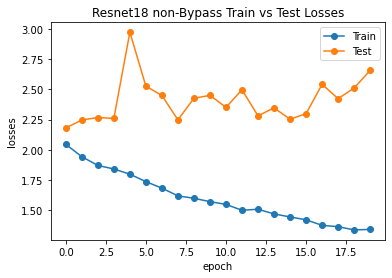

In [53]:
plt.plot(train_losses_2,'-o')
plt.plot(eval_losses_2,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Resnet18 non-Bypass Train vs Test Losses')

plt.show()

## Plot Accuracy

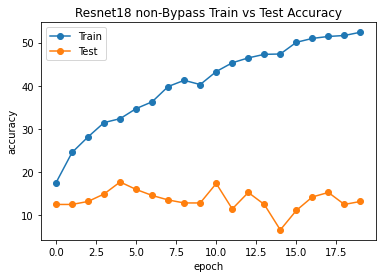

In [54]:
plt.plot(train_accu_2,'-o')
plt.plot(eval_accu_2,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Resnet18 non-Bypass Train vs Test Accuracy')

plt.show()

# Discussion: the comparison between the Bypass and the non-Bypass.
## For the training part
## Plot

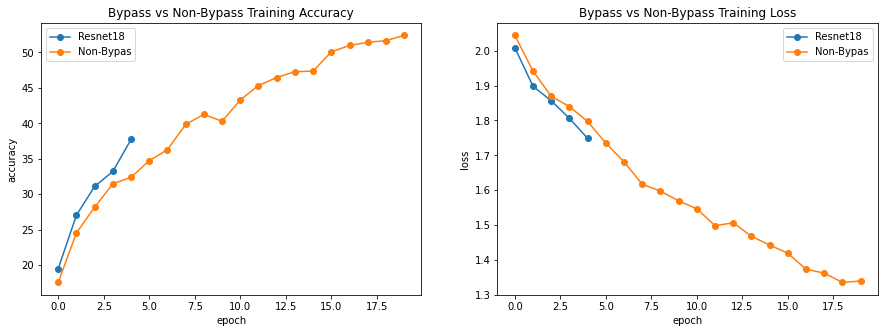

In [55]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(train_accu_1,'-o')
ax[0].plot(train_accu_2,'-o')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend(['Resnet18','Non-Bypas'])
ax[0].set_title('Bypass vs Non-Bypass Training Accuracy')

ax[1].plot(train_losses_1,'-o')
ax[1].plot(train_losses_2,'-o')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend(['Resnet18','Non-Bypas'])
ax[1].set_title('Bypass vs Non-Bypass Training Loss')

plt.show()

### 1. For the same epoch=20, the original resnet18 performs better than the bypass version in the accuracy.

### 2. For the same epoch=20, the original resnet18 performs better than the bypass version in the loss too.

### 3. Therefore, extra bypasses are good for training.

### 4. I think it is beacuse the gradient calculations are less in the back propagation step, therefore avoids the potential vanishing gradient  issues.

## For the testing part

## Plot

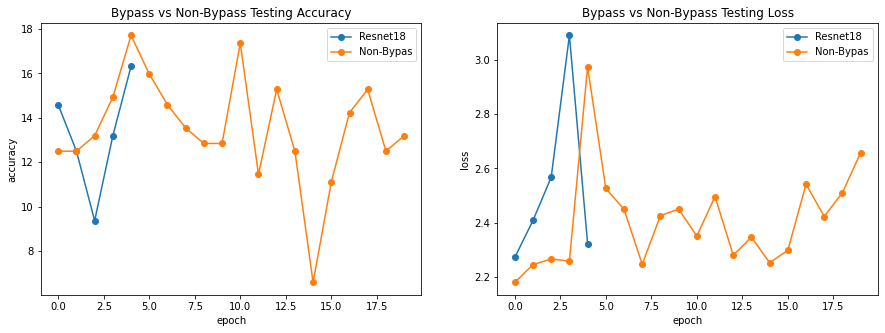

In [56]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(eval_accu_1,'-o')
ax[0].plot(eval_accu_2,'-o')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend(['Resnet18','Non-Bypas'])
ax[0].set_title('Bypass vs Non-Bypass Testing Accuracy')

ax[1].plot(eval_losses_1,'-o')
ax[1].plot(eval_losses_2,'-o')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend(['Resnet18','Non-Bypas'])
ax[1].set_title('Bypass vs Non-Bypass Testing Loss')

plt.show()

### However, it seems the non-bypass one is more stable.